In [43]:
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

np.random.seed(0)

In [44]:
INPUT_SIZE = 224
NUM_CLASSES = 120
data_dir = 'input/'
labels = pd.read_csv(join(data_dir, 'stanford_labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

30802 20580
10357 10357


In [45]:
selected_breed_list = list(labels.groupby('breed').count().head(NUM_CLASSES).index)

labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(16464, 121) (4116, 121)


In [46]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].as_matrix().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [47]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir+'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir+'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True, num_workers=4)

tibetan_terrier
english_foxhound
eskimo_dog
kuvasz
torch.Size([4, 3, 224, 224]) torch.Size([4])


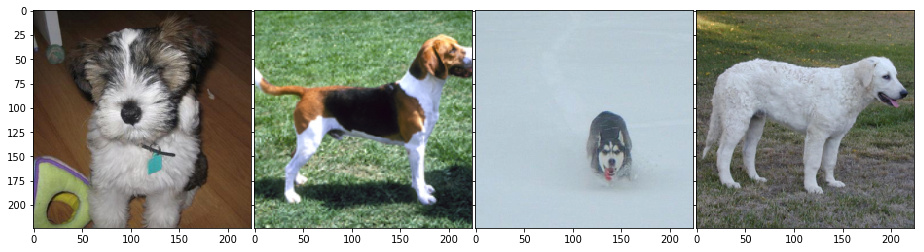

In [48]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(np.clip(inp, 0, 1))

img, label = next(iter(train_dl))
for v in label:
    print(selected_breed_list[v])

print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

In [49]:
def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(dataloders['train'].dataset), 
                     'valid': len(dataloders['valid'].dataset)}

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloders[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [50]:
resnet = models.resnet50(pretrained=True)
use_gpu = torch.cuda.is_available()
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# new final layer with NUM_CLASSES classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
if use_gpu:
    resnet = resnet.cuda()

criterion = torch.nn.CrossEntropyLoss()

#criterion = nn.ModuleCriterion(nn.ClassNLLCriterion(), nn.Log())
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dloaders = {'train':train_dl, 'valid':valid_dl}

In [51]:
start_time = time.time()
model = train_model(dloaders, resnet, criterion, optimizer, exp_lr_scheduler)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7fd128dbcf28>>
Traceback (most recent call last):
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7

RuntimeError: Traceback (most recent call last):
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 42, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 119, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 119, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 96, in default_collate
    return torch.stack(batch, 0, out=out)
  File "/home/yifuw/.local/lib/python3.5/site-packages/torch/functional.py", line 66, in stack
    return torch.cat(inputs, dim, out=out)
RuntimeError: inconsistent tensor sizes at /pytorch/torch/lib/TH/generic/THTensorMath.c:2864


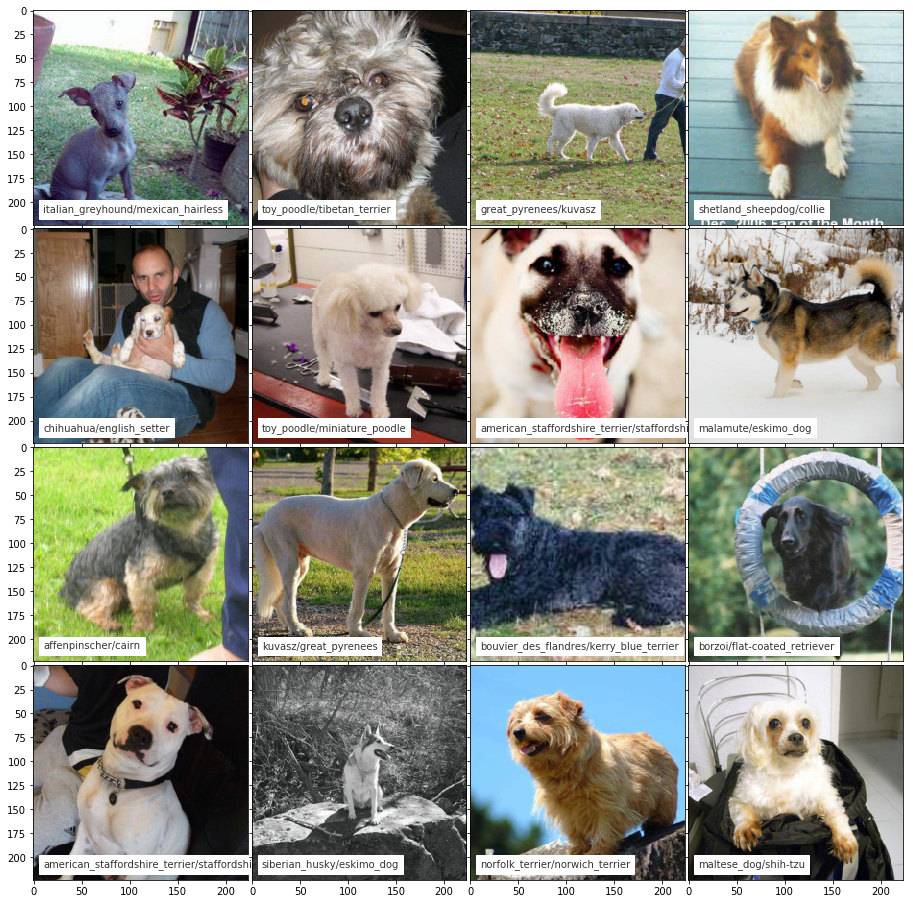

In [22]:
def visualize_model(dataloders, model, num_images=16):
    def imgshow(axis, inp):
        """Denormalize and show"""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        axis.imshow(np.clip(inp, 0, 1))
        

    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['valid']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imgshow(ax, inputs.cpu().data[j])
            if preds[j] != labels.data[j]:
                ax.text(10, 210, '{}/{}'.format(selected_breed_list[preds[j]], selected_breed_list[labels.data[j]]), 
                    color='k', backgroundcolor='w', alpha=0.8)
                cnt += 1
                if cnt == num_images:
                    return
            
visualize_model(dloaders, resnet)

In [12]:
torch.save(model, 'ResNet50-25epoch-0.822407.pt')

In [23]:
#test
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               normalize])

class DogsTestDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.root_dir = root_dir
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        if self.transform:
            image = self.transform(image)
        return image,self.labels.iloc[idx, 0]

test_ds = DogsTestDataset(sample_submission, data_dir+'test/', transform=ds_trans)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

In [24]:
import csv

with open(join(data_dir, 'test.csv'), 'w', newline='') as csvfile:
    field_names = ['id'] + sorted(selected_breed_list)
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
          
    writer.writeheader()

    for inputs,id in test_dl:
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)

        outputs = model(inputs)
        v_activation = torch.nn.functional.softmax(outputs)
        soft_prob = (v_activation.data).cpu().numpy()[0]
        soft_prob = ['{:.17f}'.format(i) for i in soft_prob]
        
        row_dict = dict(zip(selected_breed_list, soft_prob))
        row_dict['id'] = id[0]
        writer.writerow(row_dict)
    

# print(outputs)
# print(id)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
